In [24]:
import sys
import os
from os.path import exists
from datetime import datetime
from collections import OrderedDict
import json
import gc
from functools import partial

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
# from adabelief_pytorch import AdaBelief

sys.path.append('../script/')
import utils

DEVICE = 'cuda'
FOLDS = 5
MODELNAME = 'baseline1122'
now = '11-23_1818'
WEIGHT_PATHS = [f"../input/{mname}/{now}_fold{i}.pt" for i in range(FOLDS)]
PARAMS_PATH  = f"../input/{mname}/{now}_params.json"

In [25]:
## Model Here
class BaseLine(nn.Module):
    def __init__(self, num_features, num_targets, num_layers=3, dropout=.2, hidden_size=256, activation="relu", batchnorm=True, weight_norm=True):
        super().__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.utils.weight_norm(nn.Linear(num_features if len(layers)==0 else hidden_size, hidden_size, bias=(not batchnorm))))
            if batchnorm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(dropout))
            if activation == "relu":
                layers.append(nn.ReLU())
            elif activation == "prelu":
                layers.append(nn.PReLU())
            else:
                raise RuntimeError(f'{activation} is not implemented')
        # layers.append(nn.utils.weight_norm(nn.Linear(hidden_size, num_targets)))
        layers.append(nn.Linear(hidden_size, num_targets))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.model(x)
        return x

    
## Feature Engineering Here
def add_dummies(data, col):
    enc = pd.get_dummies(data[col])
    oh_cols = [f"{col}_{c}" for c in enc.columns]
    enc.columns = oh_cols
    data = data.drop(col, axis=1)
    data = data.join(enc)
    return data


def process_data(df):
    df = add_dummies(df, "cp_time")
    df = add_dummies(df, "cp_dose")
    df = add_dummies(df, "cp_type")
    return df

In [26]:
df = pd.read_csv("../input/folds/train.csv")
with open("../input/folds/targets", "r") as f:
    targets = f.read().split("\n")
with open("../input/folds/features", "r") as f:
    features = f.read().split("\n")
targets = targets[:-1]

In [27]:
params = {
    "nn_params": {
        "dropout": 0.5,
        "num_layers": 4,
        "hidden_size": 512,
        "activation": "relu",
        "batchnorm": True,
        "weight_norm": True
    },
    "optimizer": "Adam",
    "optim_params": {
        "lr": 0.01,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 1.2e-06,
        "amsgrad": False
    },
    "scheduler": "ReduceLROnPlateau",
    "scdl_params": {
        "threshold": 1e-05,
        "patience": 3
    }
}

In [28]:
predictions = np.zeros((df.shape[0], len(targets)))
for fold in range(5):
    filename = f"{MODELNAME}/{now}_fold{fold}.pt"
    print(f'[Fold No.{fold:>3}] Predicting...', end='\r')
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)
    va_idx = df[df.kfold == fold].index
    
    x_tr = train_df[features].to_numpy()
    x_va = valid_df[features].to_numpy()

    y_tr = train_df[targets].to_numpy()
    y_va = valid_df[targets].to_numpy()

    dataset_tr = utils.MoaDataset(x_tr, y_tr)
    loader_tr = torch.utils.data.DataLoader(dataset_tr, batch_size=512, num_workers=2, pin_memory=True)
    dataset_va = utils.MoaDataset(x_va, y_va)
    loader_va = torch.utils.data.DataLoader(dataset_va, batch_size=512, num_workers=2, pin_memory=True)
    
    model = BaseLine(num_features=x_tr.shape[1], num_targets=y_tr.shape[1], **params['nn_params'])
    
    weight = torch.load(filename, map_location=torch.device(DEVICE))
    weight = OrderedDict([(f'model.{k}', v) for k, v in weight.items()])
    model.load_state_dict(weight)
    
    model.eval()
    ps = []
    for ind, batch in enumerate(loader_va):
        ps.append(torch.sigmoid(model(batch["x"])).detach().cpu().numpy())
    ps = np.vstack(ps)
    predictions[va_idx] += ps
print()

[Fold No.  4] Predicting...


In [35]:
tl = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
oof = tl.copy()
oof.iloc[:,1:] = predictions
oof

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,1.560162e-03,0.000810,0.000331,0.010322,0.026190,0.005875,0.002052,0.003341,0.000174,...,0.000170,0.000316,0.002404,3.142467e-04,0.000521,0.000052,0.000944,0.000611,0.000189,0.001604
1,id_000779bfc,5.080507e-04,0.000677,0.001656,0.015546,0.015683,0.004268,0.005727,0.003624,0.000313,...,0.000709,0.000796,0.004731,1.913108e-03,0.000931,0.000292,0.000360,0.002898,0.002986,0.003362
2,id_000a6266a,8.115465e-04,0.001592,0.000361,0.001622,0.004903,0.002535,0.000682,0.007426,0.004711,...,0.000234,0.000674,0.002766,6.530091e-04,0.008250,0.000092,0.068858,0.000546,0.000440,0.001301
3,id_0015fd391,8.393127e-05,0.000204,0.001321,0.004436,0.002736,0.001525,0.000706,0.001223,0.000355,...,0.000395,0.012249,0.000737,4.255399e-01,0.008855,0.000073,0.000279,0.000700,0.000239,0.000449
4,id_001626bd3,9.649345e-04,0.001374,0.001415,0.009757,0.021396,0.005788,0.002181,0.002918,0.000406,...,0.000542,0.000968,0.003008,1.665511e-03,0.000358,0.000358,0.000171,0.001499,0.000691,0.001289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,1.011003e-03,0.001148,0.000895,0.011956,0.027320,0.005124,0.003766,0.005472,0.000151,...,0.000419,0.000426,0.004337,3.431884e-04,0.000893,0.000508,0.000612,0.001535,0.001091,0.001542
23810,id_fffb70c0c,1.090684e-03,0.000911,0.002188,0.008152,0.012709,0.002993,0.002616,0.005681,0.000434,...,0.000694,0.000803,0.001941,5.458794e-04,0.002427,0.000081,0.001215,0.001262,0.016291,0.004107
23811,id_fffc1c3f4,1.002975e-04,0.000086,0.000290,0.009502,0.004906,0.000806,0.001413,0.000714,0.000050,...,0.000027,0.000040,0.001142,4.333798e-04,0.000201,0.000028,0.000070,0.000731,0.000129,0.000579
23812,id_fffcb9e7c,3.782637e-07,0.000005,0.000053,0.000001,0.000004,0.000002,0.000008,0.000161,0.000040,...,0.000024,0.000002,0.000010,1.016705e-07,0.000232,0.000013,0.000045,0.000005,0.004769,0.000059


## oof vs target

<AxesSubplot:ylabel='Density'>

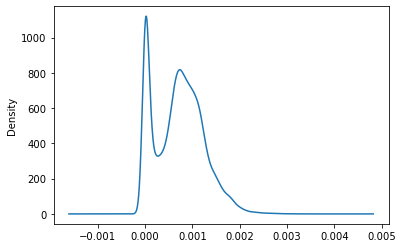

In [37]:
col = '5-alpha_reductase_inhibitor'
oof[col].plot(kind='kde')
# tl[col].plot(kind='kde')

## oof vs pred_test